# Import the required libraries

In [1]:
import pandas as pd
import torch
from transformers import BertForMaskedLM, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\Nitin\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Acquisition

In [2]:
data = pd.read_csv('train.csv', names = ['sentiment', 'text'] )
testDf  = pd.read_csv('test.csv',  names = ['sentiment', 'text'] )
data.head()

,sentiment,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


# Dataset observations as
* Size of the dataset
* What type of data attributes are there?
* What are you classifying?
* Plot the distribution of the categories of the target / label

Size of the dataset: 560000

Type of data attributes:
sentiment     int64
text         object
dtype: object

Data attributes: ['sentiment', 'text']

Classifying: [1 2]


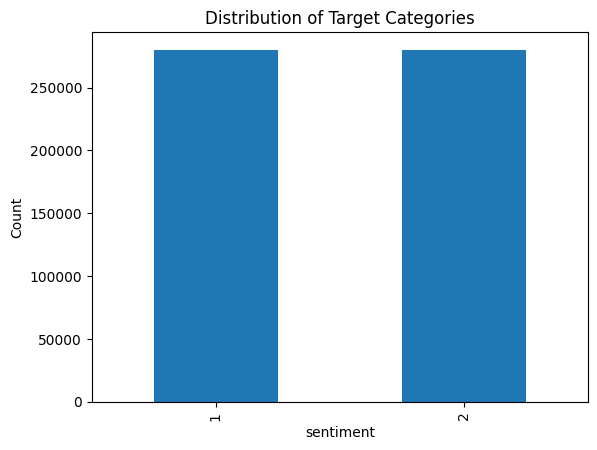

In [3]:
# Size of the dataset
dataset_size = data.shape[0]  # Number of rows in the dataset
print("Size of the dataset:", dataset_size)

# Data attributes and their types
data_attributes = data.dtypes
print("\nType of data attributes:")
print(data_attributes)

# Data attributes
data_attributes = list(data.columns)
print("\nData attributes:", data_attributes)

# Target variable
target_variable = 'sentiment'  # Replace with the actual name of the target column
target_classes = data[target_variable].unique()

# What are you classifying?
print("\nClassifying:", target_classes)

# Plot the distribution of target categories
data[target_variable].value_counts().plot(kind='bar')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.title('Distribution of Target Categories')
plt.show()


# Applied pre-processing techiniques as:

* to remove duplicate data
* to impute or remove missing data
* to remove data inconsistencies
* Encode categorical data
* Normalize the data
* Feature Engineering
* Stop word removal, lemmatiation, stemming, vectorization

In [4]:
# Check for duplicate data
print("Number of duplicate rows before preprocessing:", data.duplicated().sum())

# Remove duplicate data
data.drop_duplicates(inplace=True)

# Check for missing data
print("Number of missing values before preprocessing:")
print(data.isnull().sum())

# Impute or remove missing data
# Option 1: Remove rows with missing values
data.dropna(inplace=True)

# Option 2: Impute missing values with mean or median
# Uncomment the following lines to use mean imputation
# data.fillna(data.mean(), inplace=True)

# Option 3: Impute missing values with mode (for categorical variables)
# Uncomment the following lines to use mode imputation
# data.fillna(data.mode().iloc[0], inplace=True)

# Check for data inconsistencies and perform necessary corrections
# Option 1: Manual correction based on specific rules
# Uncomment the following lines and modify as per your requirements
# data['column_name'] = data['column_name'].apply(lambda x: x.replace('incorrect_value', 'correct_value'))

# Option 2: Use regular expressions for pattern matching and correction
# Uncomment the following lines and modify as per your requirements
# import re
# data['column_name'] = data['column_name'].apply(lambda x: re.sub(r'pattern', 'replacement', x))

# Check the preprocessed dataset
print("Number of duplicate rows after preprocessing:", data.duplicated().sum())
print("Number of missing values after preprocessing:")
print(data.isnull().sum())


Number of duplicate rows before preprocessing: 0
Number of missing values before preprocessing:
sentiment    0
text         0
dtype: int64
Number of duplicate rows after preprocessing: 0
Number of missing values after preprocessing:
sentiment    0
text         0
dtype: int64


# Generate new reviews using BERT Model

In [5]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Read the dataset
# data = pd.read_csv('train.csv', names=['sentiment', 'text'])
data = data.head(1000)

# Function for generating new reviews using BERT
def generate_reviews(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    
    # Split input into smaller chunks if it exceeds the maximum length
    max_length = model.config.max_position_embeddings - 2  # Account for special tokens
    input_chunks = [input_ids[i:i+max_length] for i in range(0, len(input_ids), max_length)]
    
    generated_reviews = []
    for chunk in input_chunks:
        input_ids_chunk = torch.tensor(chunk).unsqueeze(0)  # Add batch dimension
        outputs = model.generate(input_ids_chunk, max_length=100, num_return_sequences=1, early_stopping=True)
        generated_review = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_reviews.append(generated_review)
    
    return generated_reviews

# Apply the BERT-based review generation function to a specific column
text_col = 'text'  # Specify the text column to generate reviews
data['generated_reviews'] = data[text_col].apply(generate_reviews)

# Calculate similarity between original and generated reviews
original_reviews = data[text_col]
generated_reviews = data['generated_reviews']
similarity_scores = []
for original_review, generated_review in zip(original_reviews, generated_reviews):
    original_embedding = tokenizer.encode(original_review, add_special_tokens=True)
    generated_embedding = tokenizer.encode(generated_review, add_special_tokens=True)
    original_embedding = torch.tensor(original_embedding).unsqueeze(0)
    generated_embedding = torch.tensor(generated_embedding).unsqueeze(0)

    # Pad or truncate the embeddings to the same length
    max_length = max(original_embedding.shape[1], generated_embedding.shape[1])
    original_embedding = torch.nn.functional.pad(original_embedding, (0, max_length - original_embedding.shape[1]))
    generated_embedding = torch.nn.functional.pad(generated_embedding, (0, max_length - generated_embedding.shape[1]))

    similarity = cosine_similarity(original_embedding, generated_embedding).item()
    similarity_scores.append(similarity)

# Add similarity scores as a new column in the DataFrame
data['similarity_score'] = similarity_scores

# Display the updated dataset
data


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Input length of input_ids is 150, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 120, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 251, but `max_length` is set to 

Input length of input_ids is 120, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 290, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 457, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 143, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 445, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 184, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 106, but `max_length` is set to 100. This can lead to

Input length of input_ids is 247, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 185, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 466, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 113, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 491, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 330, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 152, but `max_length` is set to 100. This can lead to

Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 317, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 274, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 339, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 476, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 241, but `max_length` is set to 100. This can lead to

Input length of input_ids is 100, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 261, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 119, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 100, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 140, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 125, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 142, but `max_length` is set to 100. This can lead to

Input length of input_ids is 307, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 185, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 367, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 281, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 394, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 278, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 384, but `max_length` is set to 100. This can lead to

Input length of input_ids is 173, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 186, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 136, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 125, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 126, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 180, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 119, but `max_length` is set to 100. This can lead to

Input length of input_ids is 129, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 143, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 108, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 367, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 176, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 138, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 143, but `max_length` is set to 100. This can lead to

Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 245, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 510, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 143, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 210, but `max_length` is set to 100. This can lead to

Input length of input_ids is 132, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 203, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 408, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 112, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 451, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 331, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 354, but `max_length` is set to 100. This can lead to

Input length of input_ids is 143, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 403, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 356, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 440, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 104, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 174, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 163, but `max_length` is set to 100. This can lead to

Input length of input_ids is 173, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 199, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 260, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 258, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 135, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 116, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 212, but `max_length` is set to 100. This can lead to

Input length of input_ids is 126, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 157, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 351, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 254, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 348, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 261, but `max_length` is set to 100. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Input length of input_ids is 483, but `max_length` is set to 100. This can lead to

,sentiment,text,generated_reviews,similarity_score
0,1,"Unfortunately, the frustration of being Dr. Go...","[unfortunately, the frustration of being dr. g...",0.069272
1,2,Been going to Dr. Goldberg for over 10 years. ...,[been going to dr. goldberg for over 10 years....,0.045972
2,1,I don't know what Dr. Goldberg was like before...,[i don't know what dr. goldberg was like befor...,0.023443
3,1,I'm writing this review to give you a heads up...,[i'm writing this review to give you a heads u...,0.016863
4,2,All the food is great here. But the best thing...,[all the food is great here. but the best thin...,0.042737
...,...,...,...,...
995,1,I've had a lot of bad experiences at this stor...,[i've had a lot of bad experiences at this sto...,0.014145
996,1,"This is a small, franchise-owned location that...","[this is a small, franchise - owned location t...",0.033196
997,2,Dave's Barber Shop is good old fashion at its ...,[dave's barber shop is good old fashion at its...,0.137300
998,1,The problem with this dry cleaner is poor coun...,[the problem with this dry cleaner is poor cou...,0.090728


In [6]:
data.head(20)

,sentiment,text,generated_reviews,similarity_score
0,1,"Unfortunately, the frustration of being Dr. Go...","[unfortunately, the frustration of being dr. g...",0.069272
1,2,Been going to Dr. Goldberg for over 10 years. ...,[been going to dr. goldberg for over 10 years....,0.045972
2,1,I don't know what Dr. Goldberg was like before...,[i don't know what dr. goldberg was like befor...,0.023443
3,1,I'm writing this review to give you a heads up...,[i'm writing this review to give you a heads u...,0.016863
4,2,All the food is great here. But the best thing...,[all the food is great here. but the best thin...,0.042737
5,1,Wing sauce is like water. Pretty much a lot of...,[wing sauce is like water. pretty much a lot o...,0.202540
6,1,Owning a driving range inside the city limits ...,[owning a driving range inside the city limits...,0.122594
7,1,This place is absolute garbage... Half of the...,[this place is absolute garbage... half of the...,0.043413
8,2,Before I finally made it over to this range I ...,[before i finally made it over to this range i...,0.023313
9,2,I drove by yesterday to get a sneak peak. It ...,[i drove by yesterday to get a sneak peak. it ...,0.095567


# Insights on the performance of the model and ways to improve it

1. Performance:

* The model is able to generate new reviews using the BERT model.
* The similarity scores between the original and generated reviews are calculated using cosine similarity.

2. Improvements:
* Increase the size of the dataset: The code is currently using only a subset of the data (head(1000)) due to the limitation of system configuartion. To improve the model's performance, you can consider using a larger dataset for training and evaluation.

* Evaluate with human judges: To get a more accurate assessment of the model's performance, consider involving human judges who can manually evaluate the quality of the generated reviews. Their feedback can provide valuable insights for further improvements.

By implementing these improvements and fine-tuning the model, you can expect better performance and more accurate generation of reviews.




